In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math

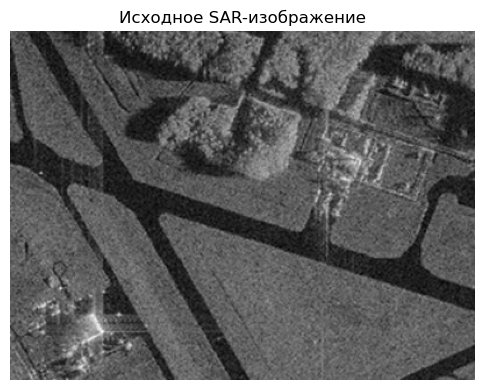

In [2]:
image_path = 'sar_1.jpg'
image = cv2.imread(image_path)
if image is None:
    raise FileNotFoundError(f"Изображение {image_path} не найдено!")

image_gray = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(6,6))
plt.imshow(image_gray, cmap='gray')
plt.title('Исходное SAR-изображение')
plt.axis('off')
plt.show()


In [3]:
# 1. Подбор параметров Region Growing для выделения газона
def homo_average(img, mask, point, T):
    region = img[mask > 0]
    if len(region) == 0:
        return False
    av_val = region.mean()
    return abs(av_val - img[point]) <= T


In [5]:
def region_growing(image, seed_point, homo_fun, r, T):
    mask = np.zeros(image.shape, np.uint8)
    mask[seed_point] = 1
    count = 1
    
    while count > 0:
        count = 0
        local_mask = np.zeros(image.shape, np.uint8)
        
        for i in range(r, image.shape[0] - r):
            for j in range(r, image.shape[1] - r):
                if mask[i, j] == 0 and mask[i-r:i+r+1, j-r:j+r+1].sum() > 0:
                    if homo_fun(image, mask, (i, j), T):
                        local_mask[i, j] = 1
                        
        count = np.count_nonzero(local_mask)
        mask += local_mask
        
    return mask * 255


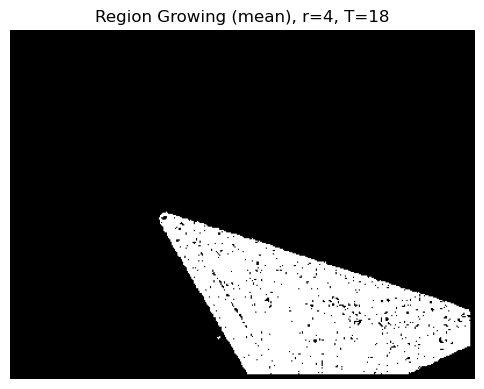

In [6]:
seed_point = (250, 250)

r = 4      # радиус соседства
T = 18     # порог однородности

mask_avg = region_growing(image_gray, seed_point, homo_average, r, T)

plt.figure(figsize=(6,6))
plt.imshow(mask_avg, cmap='gray')
plt.title(f'Region Growing (mean), r={r}, T={T}')
plt.axis('off')
plt.show()


In [7]:
# 2. Новый критерий однородности (стандартное отклонение)
def homo_std(img, mask, point, T):
    region = img[mask > 0]
    if len(region) == 0:
        return False
    
    mu = region.mean()
    sigma = region.std()
    
    k = 1.5                 
    threshold = k * sigma + T
    return abs(img[point] - mu) <= threshold


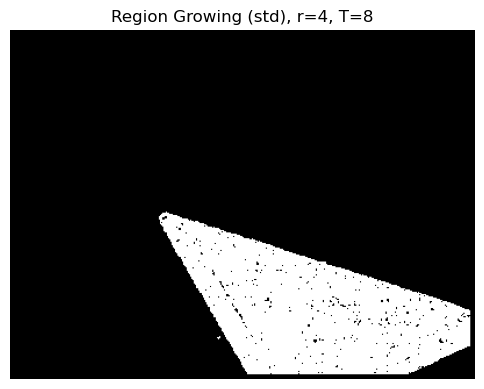

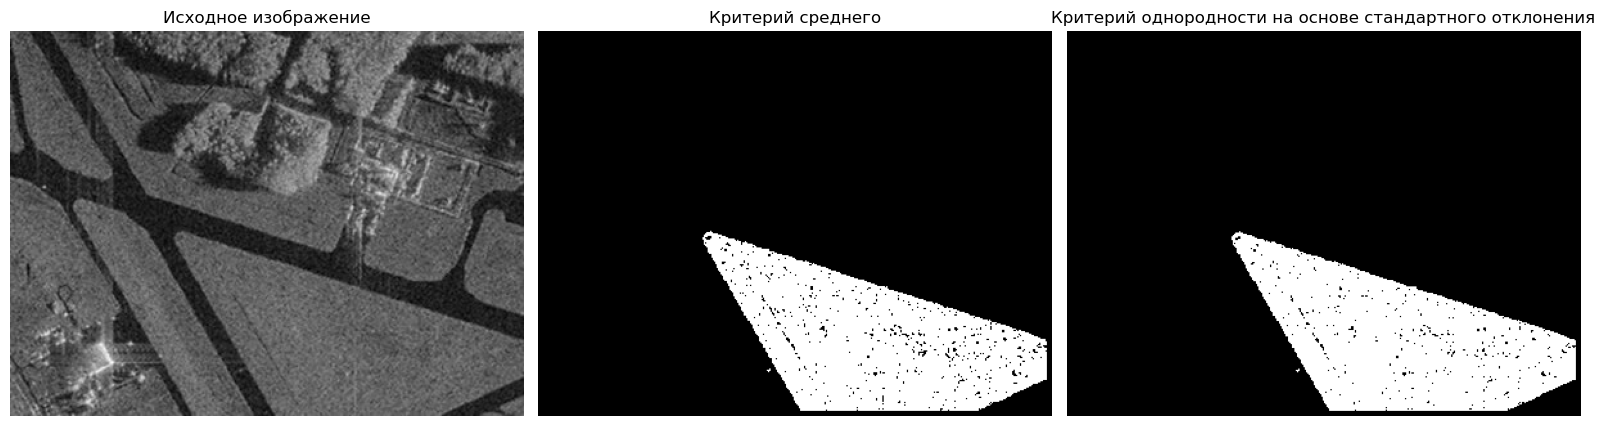

Площадь региона (mean): 19976
Площадь региона (std): 20284


In [9]:
T_std = 8 

mask_std = region_growing(image_gray, seed_point, homo_std, r, T_std)

plt.figure(figsize=(6,6))
plt.imshow(mask_std, cmap='gray')
plt.title(f'Region Growing (std), r={r}, T={T_std}')
plt.axis('off')
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(16,5))

axes[0].imshow(image_gray, cmap='gray')
axes[0].set_title('Исходное изображение')
axes[0].axis('off')

axes[1].imshow(mask_avg, cmap='gray')
axes[1].set_title('Критерий среднего')
axes[1].axis('off')

axes[2].imshow(mask_std, cmap='gray')
axes[2].set_title('Критерий однородности на основе стандартного отклонения')
axes[2].axis('off')

plt.tight_layout()
plt.show()

print("Площадь региона (mean):", np.count_nonzero(mask_avg))
print("Площадь региона (std):", np.count_nonzero(mask_std))


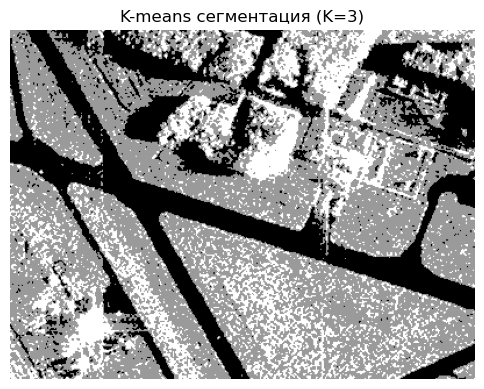

In [10]:
# K-means сегментация по яркости
Z = image_gray.reshape((-1,1)).astype(np.float32)

K = 3
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 20, 1.0)
ret, label, center = cv2.kmeans(Z, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

center = np.uint8(center)
res = center[label.flatten()]
kmeans_seg = res.reshape((image_gray.shape))

plt.figure(figsize=(6,6))
plt.imshow(kmeans_seg, cmap='gray')
plt.title('K-means сегментация (K=3)')
plt.axis('off')
plt.show()

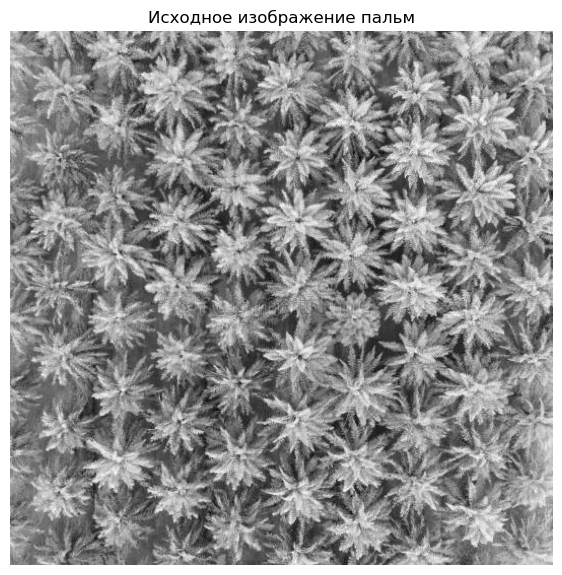

In [11]:
# 3. Watershed + Distance Transform для подсчёта пальмовых деревьев
palm_path = 'palm_1.JPG'
image_palm = cv2.imread(palm_path)
if image_palm is None:
    raise FileNotFoundError(f"Изображение {palm_path} не найдено!")

image_palm_gray = cv2.imread(palm_path, cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(7,7))
plt.imshow(image_palm_gray, cmap='gray')
plt.title('Исходное изображение пальм')
plt.axis('off')
plt.show()


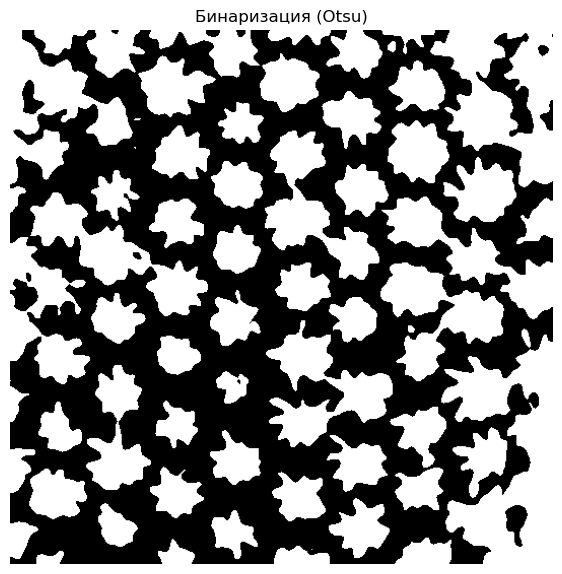

In [12]:
blur = cv2.GaussianBlur(image_palm_gray, (21, 21), 0)
ret, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

plt.figure(figsize=(7,7))
plt.imshow(thresh, cmap='gray')
plt.title('Бинаризация (Otsu)')
plt.axis('off')
plt.show()


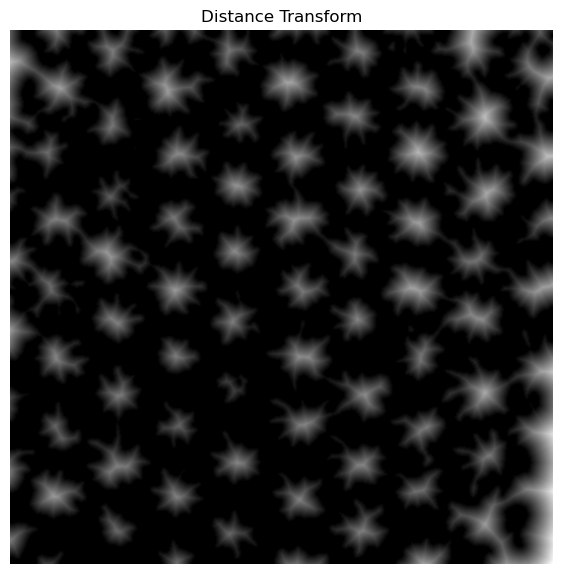

In [13]:
dist = cv2.distanceTransform(thresh, cv2.DIST_L2, 5)

plt.figure(figsize=(7,7))
plt.imshow(dist, cmap='gray')
plt.title('Distance Transform')
plt.axis('off')
plt.show()


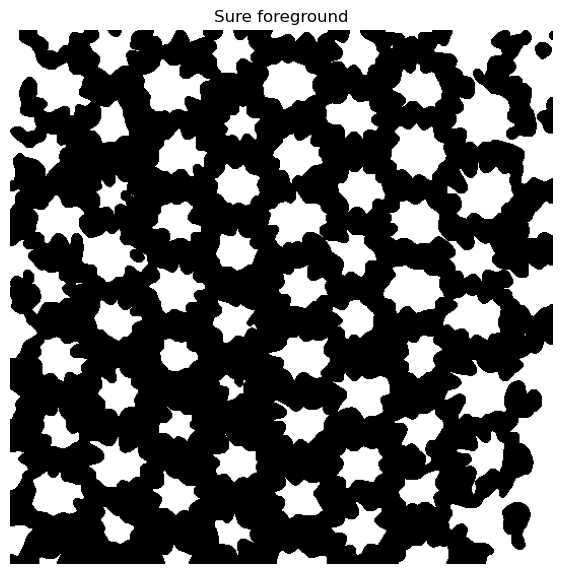

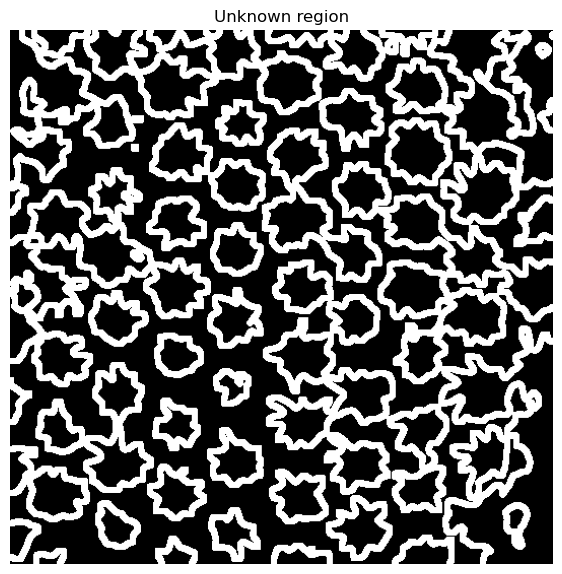

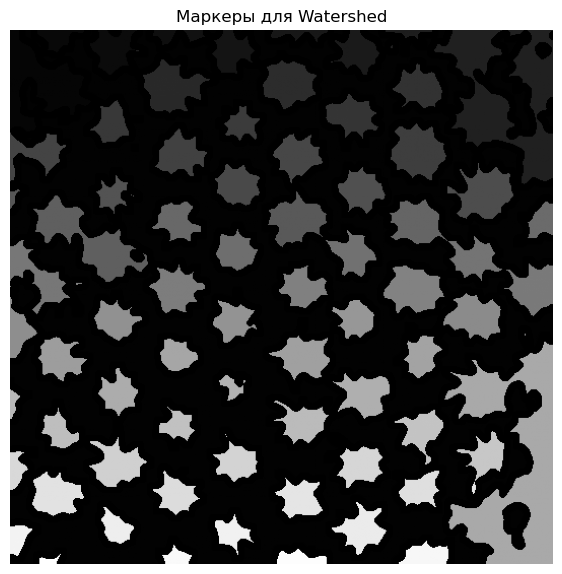

In [16]:
# Уверенные объекты — порог по Distance Transform
ret, sure_fg = cv2.threshold(dist, 0.1 * dist.max(), 255, cv2.THRESH_BINARY)
sure_fg = sure_fg.astype(np.uint8)

plt.figure(figsize=(7,7))
plt.imshow(sure_fg, cmap='gray')
plt.title('Sure foreground')
plt.axis('off')
plt.show()

# Уверенный фон
kernel = np.ones((3,3), np.uint8)
sure_bg = cv2.dilate(thresh, kernel, iterations=3)

unknown = cv2.subtract(sure_bg, sure_fg)

plt.figure(figsize=(7,7))
plt.imshow(unknown, cmap='gray')
plt.title('Unknown region')
plt.axis('off')
plt.show()

# Маркеры связных компонент
ret, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1            
markers[unknown == 255] = 0      

plt.figure(figsize=(7,7))
plt.imshow(markers, cmap='gray')
plt.title('Маркеры для Watershed')
plt.axis('off')
plt.show()

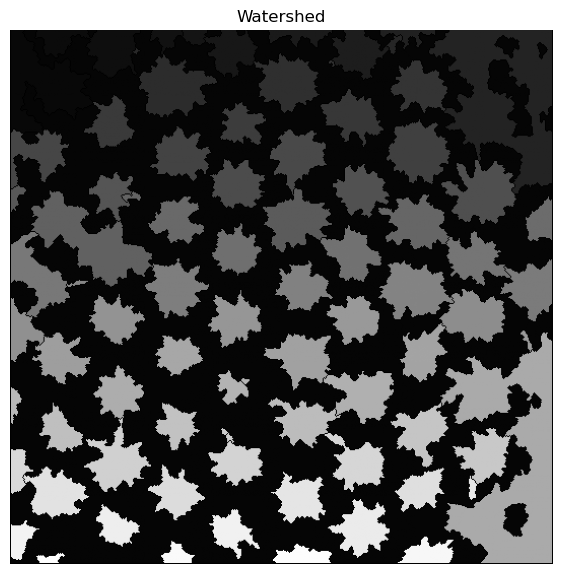

In [19]:
markers_ws = cv2.watershed(image_palm, markers.copy())

plt.figure(figsize=(7,7))
plt.imshow(markers_ws, cmap='gray')
plt.title('Watershed')
plt.axis('off')
plt.show()